In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr, ttest_1samp

In [2]:
# Read input data
gen_cor = pd.read_csv('gen_cor.csv')
obs_cor = pd.read_csv('obs_cor.csv')

inputs = gen_cor.merge(obs_cor, on=['head_node', 'tail_node']).drop_duplicates()

In [3]:
# Check that we have each pair twice ([x, y] and [y, x]) for merge with directed graph
edges = [[row.head_node, row.tail_node] for i, row in inputs.iterrows()]
reverse_check = [edge[::-1] in edges for edge in edges]
assert sum(reverse_check) == len(inputs)

In [4]:
# Read target data
edges = pd.read_csv('../../data/processed/mr-eve-edgelist.csv')
X_y = inputs.merge(edges, on=['head_node', 'tail_node']).drop_duplicates()
del edges

# Save merged edgelist for embedding 
trait_corr_edges = X_y[['head_node', 'tail_node', 'neglog_pval', 'abs_effect']].drop_duplicates()
trait_corr_edges.to_csv('MR_obscor_gencor_edgelist.csv', index=False)

In [5]:
# Prepare X and y dataframes
X_corr = X_y[['rg', 'ro']]
y_effect = X_y['abs_effect']
y_pval = X_y['neglog_pval']

# Regress absolute effect size

In [6]:
# Fit model on effect size edge weights
effect_model = LinearRegression().fit(X_corr, y_effect)
effect_r2 = effect_model.score(X_corr, y_effect)
print(f'Regression of absolute effect on genetic and observational correlation.')
print(f'R2 = {effect_r2}')

Regression of absolute effect on genetic and observational correlation.
R2 = 0.4049629463829636


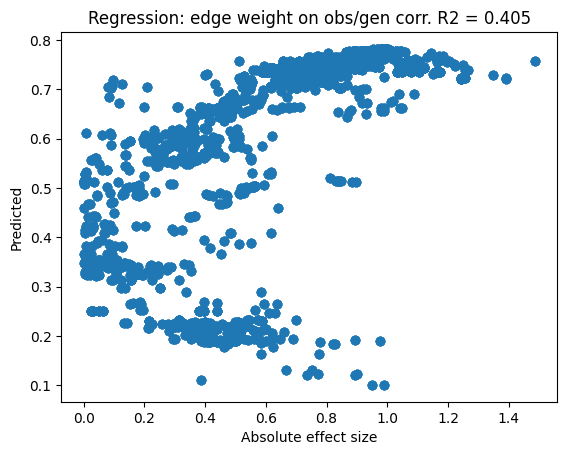

In [7]:
# Plot fitted values against actual weights
plt.scatter(y_effect, effect_model.predict(X_corr))
plt.title(f'Regression: edge weight on obs/gen corr. R2 = {round(effect_r2, 3)}')
plt.ylabel('Predicted')
plt.xlabel('Absolute effect size')
plt.show()

In [8]:
mae_scores = []
r2_scores = []
k = 5
pred_store_pval = []
for train_index, test_index in KFold(k).split(X_corr.index):
    X_train = X_corr.loc[train_index]
    X_test = X_corr.loc[test_index]
    y_train = y_effect.loc[train_index]
    y_test = y_effect.loc[test_index]

    model = LinearRegression().fit(X_train, y_train)
    preds = model.predict(X_test)
    preds = [val if val > 0 else 0 for val in preds] # Negative preds are meaningless
    pred_store_pval += preds
    mae_scores.append(mean_absolute_error(y_test, preds))
    r2_scores.append(model.score(X_test, y_test))

print(f'{k}-fold cross-validation for regression of absolute effect size on correlation data')
print(f'\nMean absolute errors of predictions per fold (mean={round(np.mean(mae_scores), 3)}):\n')
print(mae_scores)
print(f'\n\nOut-of-sample model fits(mean={round(np.mean(r2_scores), 3)}):\n')
print(r2_scores)

5-fold cross-validation for regression of absolute effect size on correlation data

Mean absolute errors of predictions per fold (mean=0.208):

[0.21882552923222545, 0.1735581720354574, 0.2283866686492731, 0.2088811148105836, 0.2091333645820716]


Out-of-sample model fits(mean=0.36):

[0.3467193818748585, 0.153662843495328, 0.4049748113981372, 0.40353926017456854, 0.48991772968846314]


In [9]:
# Nowr regress on correlation and embedding data
effect_embeds = pd.read_csv('effect_best_embeds.edgevectors', skiprows=1, header=None).dropna(how='all', axis='columns')
X_y_effect = X_y.merge(effect_embeds, left_on=['head_node', 'tail_node'], right_on=[0, 1])
X_cols = ['rg', 'ro'] + [i for i in range(3, len(effect_embeds.columns)+1)]
X_effect = X_y_effect[X_cols]


effect_embed_model = LinearRegression().fit(X_effect, y_effect)
effect_embed_r2 = effect_embed_model.score(X_effect, y_effect)
print(f'Regression of absolute effect on genetic and observational correlation AND node2vec embeddings.')
print(f'R2 = {effect_embed_r2}')


Regression of absolute effect on genetic and observational correlation AND node2vec embeddings.
R2 = 0.7053827319968097


In [10]:
X_effect_embed = X_effect.drop(['rg', 'ro'], axis=1)
mae_scores = []
r2_scores = []
k = 5
pred_store_pval = []
for train_index, test_index in KFold(k).split(X_corr.index):
    X_train = X_effect_embed.loc[train_index]
    X_test = X_effect_embed.loc[test_index]
    y_train = y_effect.loc[train_index]
    y_test = y_effect.loc[test_index]

    model = LinearRegression().fit(X_train, y_train)
    preds = model.predict(X_test)
    preds = [val if val > 0 else 0 for val in preds] # Negative preds are meaningless
    pred_store_pval += preds
    mae_scores.append(mean_absolute_error(y_test, preds))
    r2_scores.append(model.score(X_test, y_test))

print(f'{k}-fold cross-validation for regression of absolute effect size on embedding data')
print(f'\nMean absolute errors of predictions per fold (mean={round(np.mean(mae_scores), 3)}):\n')
print(mae_scores)
print(f'\n\nOut-of-sample model fits(mean={round(np.mean(r2_scores), 3)}):\n')
print(r2_scores)

5-fold cross-validation for regression of absolute effect size on embedding data

Mean absolute errors of predictions per fold (mean=0.204):

[0.23180755945039516, 0.185637020734488, 0.20519763762276882, 0.1842117908304862, 0.21155564282567227]


Out-of-sample model fits(mean=-0.147):

[-0.5248532007344904, -1.609095428380459, 0.4625801212295094, 0.4930915959437696, 0.4421337607821778]


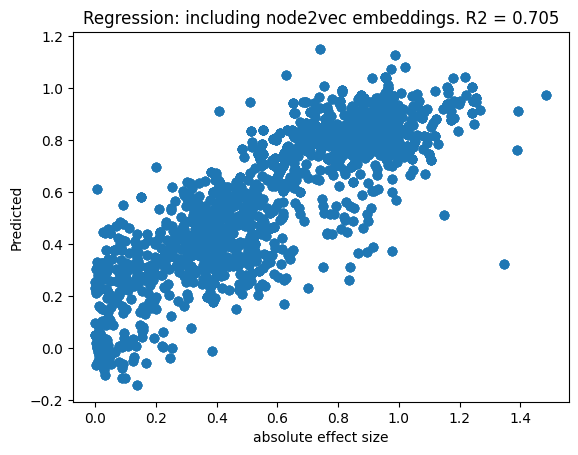

In [11]:
plt.scatter(y_effect, effect_embed_model.predict(X_effect))
plt.title(f'Regression: including node2vec embeddings. R2 = {round(effect_embed_r2, 3)}')
plt.ylabel('Predicted')
plt.xlabel('absolute effect size')
plt.show()

# Regress -log(pval) 

In [12]:
# Fit model on pval edge weights
pval_model = LinearRegression().fit(X_corr, y_pval)
pval_r2 = pval_model.score(X_corr, y_pval)
print(f'Regression of -log10(pval) on genetic and observational correlation.')
print(f'R2 = {pval_r2}')

Regression of -log10(pval) on genetic and observational correlation.
R2 = 0.578492961425477


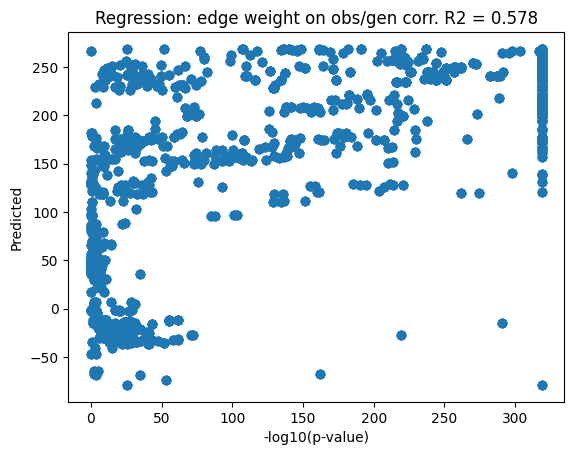

In [13]:
plt.scatter(y_pval, pval_model.predict(X_corr))
plt.title(f'Regression: edge weight on obs/gen corr. R2 = {round(pval_r2, 3)}')
plt.ylabel('Predicted')
plt.xlabel('-log10(p-value)')
plt.show()

In [14]:
mae_scores = []
r2_scores = []
k = 5
pred_store_pval = []
for train_index, test_index in KFold(k).split(X_corr.index):
    X_train = X_corr.loc[train_index]
    X_test = X_corr.loc[test_index]
    y_train = y_pval.loc[train_index]
    y_test = y_pval.loc[test_index]

    model = LinearRegression().fit(X_train, y_train)
    preds = model.predict(X_test)
    preds = [val if val > 0 else 0 for val in preds] # Negative preds are meaningless
    pred_store_pval += preds
    mae_scores.append(mean_absolute_error(y_test, preds))
    r2_scores.append(model.score(X_test, y_test))

print(f'{k}-fold cross-validation for regression of transformed p-value on correlation data')
print(f'\nMean absolute errors of predictions per fold (mean={round(np.mean(mae_scores), 3)}):\n')
print(mae_scores)
print(f'\n\nOut-of-sample model fits(mean={round(np.mean(r2_scores), 3)}):\n')
print(r2_scores)

5-fold cross-validation for regression of transformed p-value on correlation data

Mean absolute errors of predictions per fold (mean=70.54):

[72.90403002106203, 72.30543963062678, 70.69913122821826, 72.41302280263939, 64.37993934284107]


Out-of-sample model fits(mean=0.567):

[0.48787500842713627, 0.5143586909539419, 0.5473706445603271, 0.6138218922911534, 0.671815649167069]


In [15]:
pval_embeds = pd.read_csv('pval_best_embeds.edgevectors', skiprows=1, header=None).dropna(how='all', axis='columns')
X_y_pval = X_y.merge(pval_embeds, left_on=['head_node', 'tail_node'], right_on=[0, 1])
X_cols = ['rg', 'ro'] + [i for i in range(3, len(pval_embeds.columns)+1)]
X_pval = X_y_pval[X_cols]


pval_embed_model = LinearRegression().fit(X_pval, y_pval)
pval_embed_r2 = pval_embed_model.score(X_pval, y_pval)
print(f'Regression of absolute effect on genetic and observational correlation AND node2vec embeddings.')
print(f'R2 = {pval_embed_r2}')

Regression of absolute effect on genetic and observational correlation AND node2vec embeddings.
R2 = 0.7281511403144323


In [16]:
X_pval_embed = X_pval.drop(['rg', 'ro'], axis=1)
mae_scores = []
r2_scores = []
k = 5
pred_store_pval = []
for train_index, test_index in KFold(k).split(X_corr.index):
    X_train = X_pval_embed.loc[train_index]
    X_test = X_pval_embed.loc[test_index]
    y_train = y_pval.loc[train_index]
    y_test = y_pval.loc[test_index]

    model = LinearRegression().fit(X_train, y_train)
    preds = model.predict(X_test)
    preds = [val if val > 0 else 0 for val in preds] # Negative preds are meaningless
    pred_store_pval += preds
    mae_scores.append(mean_absolute_error(y_test, preds))
    r2_scores.append(model.score(X_test, y_test))

print(f'{k}-fold cross-validation for regression of absolute effect size on embedding data')
print(f'\nMean absolute errors of predictions per fold (mean={round(np.mean(mae_scores), 3)}):\n')
print(mae_scores)
print(f'\n\nOut-of-sample model fits(mean={round(np.mean(r2_scores), 3)}):\n')
print(r2_scores)

5-fold cross-validation for regression of absolute effect size on embedding data

Mean absolute errors of predictions per fold (mean=68.175):

[78.08981583741402, 66.27704477893172, 64.81609412959801, 67.74384973384998, 63.949082802400866]


Out-of-sample model fits(mean=0.285):

[-0.7101073926392132, 0.27178792986360634, 0.6178483754862228, 0.6205563339726506, 0.6257960127273479]


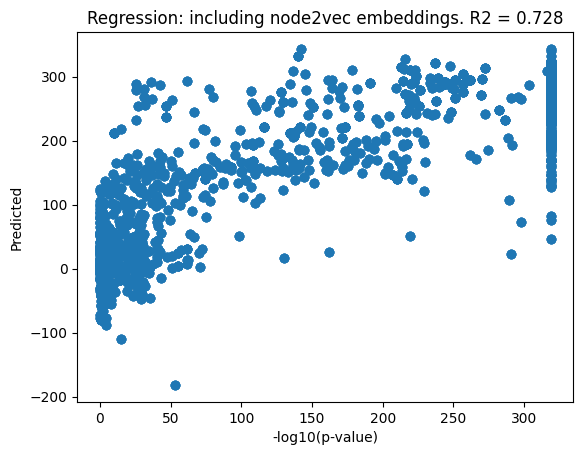

In [17]:
plt.scatter(y_pval, pval_embed_model.predict(X_pval))
plt.title(f'Regression: including node2vec embeddings. R2 = {round(pval_embed_r2, 3)}')
plt.ylabel('Predicted')
plt.xlabel('-log10(p-value)')
plt.show()

# Assess predictive accuracy of models on out-of-sample data

In [18]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold

In [19]:
# Pval embeddings

mae_scores = []
r2_scores = []
k = 5
pred_store_pval = []
for train_index, test_index in KFold(k).split(X_pval.index):
    X_train = X_pval.loc[train_index]
    X_test = X_pval.loc[test_index]
    y_train = y_pval.loc[train_index]
    y_test = y_pval.loc[test_index]

    model = LinearRegression().fit(X_train, y_train)
    preds = model.predict(X_test)
    preds = [val if val > 0 else 0 for val in preds] # Negative preds are meaningless
    pred_store_pval += preds
    mae_scores.append(mean_absolute_error(y_test, preds))
    r2_scores.append(model.score(X_test, y_test))

print(f'{k}-fold cross-validation for regression of transformed p-value on correlation data and node2vec embeddings')
print(f'\nMean absolute errors of predictions per fold (mean={round(np.mean(mae_scores), 3)}):\n')
print(mae_scores)
print(f'\n\nOut-of-sample model fits(mean={round(np.mean(r2_scores), 3)}):\n')
print(r2_scores)

5-fold cross-validation for regression of transformed p-value on correlation data and node2vec embeddings

Mean absolute errors of predictions per fold (mean=59.457):

[63.047845259152105, 67.64040202180416, 56.16837795924525, 58.80024377028177, 51.628656109134035]


Out-of-sample model fits(mean=0.462):

[-0.06266703995649703, 0.4362193742374135, 0.5129025869818724, 0.692517460594273, 0.7292306607458321]


In [20]:
plt.scatter(y_pval, pred_store_pval)
plt.suptitle(f'Transformed pval: out-of-sample predictions from correlation data + embeddings')
plt.title(f'Pearson r = {round(pearsonr(y_pval, pred_store_pval)[0], 3)}')
plt.ylabel('Predicted')
plt.xlabel('-log10(p-value)')
plt.show()

NameError: name 'pearsonr' is not defined

In [35]:
# Effect size embeddings

mae_scores = []
r2_scores = []
k = 5
pred_store = []
for train_index, test_index in KFold(k).split(X_pval.index):
    X_train = X_effect.loc[train_index]
    X_test = X_effect.loc[test_index]
    y_train = y_effect.loc[train_index]
    y_test = y_effect.loc[test_index]

    model = LinearRegression().fit(X_train, y_train)
    preds = model.predict(X_test)
    preds = [val if val > 0 else 0 for val in preds] # Negative preds are meaningless
    pred_store += preds
    mae_scores.append(mean_absolute_error(y_test, preds))
    r2_scores.append(model.score(X_test, y_test))
    

print(f'{k}-fold cross-validation for regression of absolute effect size on correlation data and node2vec embeddings')
print(f'\nMean absolute errors of predictions per fold (mean={round(np.mean(mae_scores), 3)}):\n')
print(mae_scores)
print(f'\n\nOut-of-sample model fits(mean={round(np.mean(r2_scores), 3)}):\n')
print(r2_scores)

5-fold cross-validation for regression of absolute effect size on correlation data and node2vec embeddings

Mean absolute errors of predictions per fold (mean=0.178):

[0.1988913553178953, 0.20438591850682322, 0.17545426961656943, 0.14311181095310802, 0.1679102068552915]


Out-of-sample model fits(mean=0.206):

[-0.014424652727546228, -0.76563098619068, 0.49636686336292224, 0.6852980847226233, 0.628257871363461]


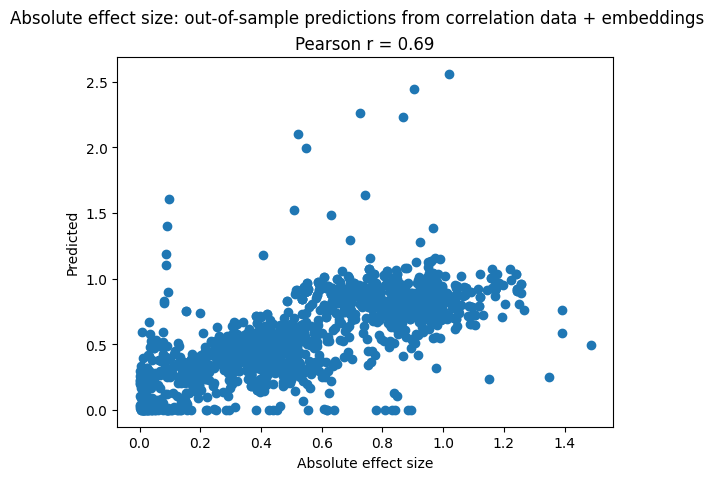

In [55]:
plt.scatter(y_effect, pred_store)
plt.suptitle(f'Absolute effect size: out-of-sample predictions from correlation data + embeddings')
plt.title(f'Pearson r = {round(pearsonr(y_effect, pred_store)[0], 3)}')
plt.ylabel('Predicted')
plt.xlabel('Absolute effect size')
plt.show()

# Using both embedding sets together

In [19]:
X_all = X_y[['trait1','trait2','rg','rg_SE']]
X_all = X_all.merge(effect_embeds, left_on=['trait1', 'trait2'], right_on=[0, 1]).drop([0, 1], axis=1)
X_all = X_all.merge(pval_embeds, left_on=['trait1', 'trait2'], right_on=[0, 1]).drop([0, 1, 'trait1', 'trait2'], axis=1)

X_all

,rg,rg_SE,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,...,57_y,58_y,59_y,60_y,61_y,62_y,63_y,64_y,65_y,66_y
0,0.6996,0.016720,0.533928,0.287636,0.232451,0.045393,0.003384,0.323227,0.029613,0.432905,...,0.226655,0.223914,0.095850,0.216402,0.155636,0.193841,0.201834,0.224954,0.392684,0.126158
1,0.6998,0.016700,0.266765,0.510152,0.249006,0.042342,0.094426,0.136297,0.034642,0.318377,...,0.137300,0.084542,0.129757,0.134788,0.175094,0.064447,0.179296,0.094660,0.235410,0.011840
2,0.6973,0.015740,0.532315,0.341501,0.214733,0.098200,0.017814,0.324325,0.018361,0.415864,...,0.218358,0.279500,0.059785,0.091009,0.220068,0.100224,0.281607,0.207306,0.278247,0.187507
3,0.6949,0.015790,0.532315,0.341501,0.214733,0.098200,0.017814,0.324325,0.018361,0.415864,...,0.218358,0.279500,0.059785,0.091009,0.220068,0.100224,0.281607,0.207306,0.278247,0.187507
4,0.6973,0.015740,0.586771,0.349153,0.224450,0.085716,0.039275,0.306087,0.020176,0.463277,...,0.258885,0.321400,0.043596,0.082329,0.240793,0.075180,0.276021,0.232642,0.239290,0.156851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1400,1.0000,0.000028,0.653055,0.398052,0.315231,0.008862,0.042452,0.343651,0.031224,0.445514,...,0.254086,0.205216,0.158016,0.285851,0.172636,0.255767,0.231941,0.181706,0.426312,0.189416
1401,0.9741,0.010750,0.160552,1.063920,0.526166,0.037088,0.044921,1.002569,0.544705,0.231143,...,0.008015,0.453113,0.198951,1.033372,0.269036,2.197836,0.194546,0.955529,0.377835,0.001180
1402,0.3914,0.069860,0.305066,0.337461,0.212509,0.194223,1.406280,0.306223,0.107569,0.007915,...,0.212251,0.187573,0.014088,0.409863,0.534670,1.134671,0.082983,0.620156,0.953542,0.238873
1403,-0.5639,0.057870,0.027982,0.829954,0.615780,0.541214,0.123028,0.334387,0.439576,0.059077,...,0.487715,0.460158,0.909326,0.680394,0.062452,0.293469,0.121937,0.190709,0.206571,0.075945


In [20]:
# In-sample model fits

# Pval regression
pval_vs_all = LinearRegression().fit(X_all, y_pval)
print(f'Transformed p-value regressed on correlation data and both embedding sets. R2 = {pval_vs_all.score(X_all, y_pval)}')

# Effect regression
effect_vs_all = LinearRegression().fit(X_all, y_effect)
print(f'Absolute effect size regressed on correlation data and both embedding sets. R2 = {effect_vs_all.score(X_all, y_effect)}')

Transformed p-value regressed on correlation data and both embedding sets. R2 = 0.7935475399694604
Absolute effect size regressed on correlation data and both embedding sets. R2 = 0.8304748644852482


# Compare fits for trait-corr network vs random subgraphs of same size

In [27]:
from string import ascii_lowercase as alphabet
path = '../node2vec/'
resultfile = '/model_fit_results.csv'
trait_corr_results = pd.read_csv(path + 'effect_trait_corr' + resultfile)
best_results = [['trait_corr_network', 119, len(trait_corr_edges), max(trait_corr_results.R2)]]
experiment_dirs = [dir for dir in os.listdir(path) if dir.startswith('mreve119')]
for dir in experiment_dirs:
    try:
        result = pd.read_csv(path + dir + resultfile)
    except:
        continue
    letter_key = dir.split('_')[-1]
    edgelist = pd.read_csv(f'../../data/processed/subgraphs/mreve_119_nodes_{letter_key}.csv')
    best_results.append([dir, 119, len(edgelist), max(result.R2)])
compare_df = pd.DataFrame(best_results, columns=['dataset', 'num_nodes', 'num_edges', 'best_R2'])
compare_df['node_selection_method'] = ['Random sample' if 'mreve' in name else 'Gen/obs-corr traits' for name in compare_df.dataset]
compare_df['density'] = compare_df.num_edges/(compare_df.num_nodes*compare_df.num_nodes - 1)
compare_df

,dataset,num_nodes,num_edges,best_R2,node_selection_method,density
0,trait_corr_network,119,1214,0.577201,Gen/obs-corr traits,0.085734
1,mreve119_bk,119,2771,0.135498,Random sample,0.195692
2,mreve119_ad,119,1828,0.233543,Random sample,0.129096
3,mreve119_bl,119,2437,0.147010,Random sample,0.172105
4,mreve119_ac,119,2831,0.139419,Random sample,0.199929
...,...,...,...,...,...,...
95,mreve119_o,119,1581,0.303975,Random sample,0.111653
96,mreve119_cp,119,3218,0.106522,Random sample,0.227260
97,mreve119_z,119,2419,0.173173,Random sample,0.170833
98,mreve119_s,119,1892,0.201030,Random sample,0.133616


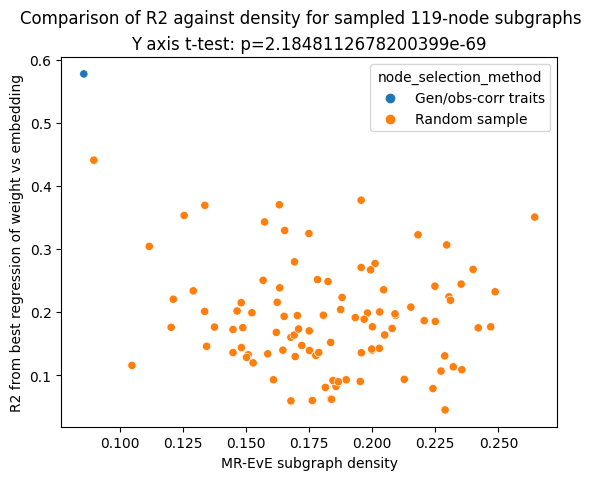

In [38]:
random_r2s = compare_df.loc[compare_df.node_selection_method == 'Random sample'].best_R2.values
corr_network_r2 = compare_df.loc[compare_df.node_selection_method == 'Gen/obs-corr traits'].best_R2.values[0]
ttest = ttest_1samp(random_r2s, corr_network_r2)

sns.scatterplot('density', 'best_R2', hue='node_selection_method', data=compare_df)
plt.ylabel('R2 from best regression of weight vs embedding')
plt.xlabel('MR-EvE subgraph density')
plt.suptitle('Comparison of R2 against density for sampled 119-node subgraphs')
plt.title(f'Y axis t-test: p={ttest.pvalue}')
plt.show()